# Linear regression: regularization and logistic regression

Today we will look at two very useful extensions of linear regression algorithms.

In [221]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 100

## Step 1: Generate Data

First let's generate a dataset with more than one feature variable to explore algorithms that can be used to reduce overfitting.

In [222]:
np.random.seed(16) #set seed for reproducibility purposes

x1 = np.arange(100)

x2 = np.linspace(0,1,100)

x3 = np.logspace(2,3,num=100) 

ypb = 3*x1 + 0.5*x2 + 15*x3 + 3 + 5*(np.random.poisson(3*x1 + 0.5*x2 + 15*x3,100)-(3*x1 + 0.5*x2 + 15*x3)) 
                                                    #generate some data with scatter following Poisson distribution 
                                                    #with exp value = y from linear model, centered around 0
        
xb = np.vstack((x1,x2,x3)).T # this gives us three features

Now we add correlated features with a polynomial transformation:

In [223]:
poly = PolynomialFeatures(2, include_bias=False)

new_xb = poly.fit_transform(xb) # this dives us 9 features total

new_xb.shape

(100, 9)

## Step 2:  Ridge regression

Set up Ridge regression, and determine cross-validated scores for different values of alpha that are logarithmically spaced in the rage between $10^{-6}$ and $10^6$, then find the best alpha that optimizes the test score. For this to be meaningful, the data should be standardized, so please set up a pipeline with Ridge() and the StandardScaler() you used earlier. Make a plot of mean test scores versus alpha. Which scale is more appropriate, linear or logarithmic?

**Log scale is more appropriate, as the alpha spans wide**

Best alpha: 8.858667904100814


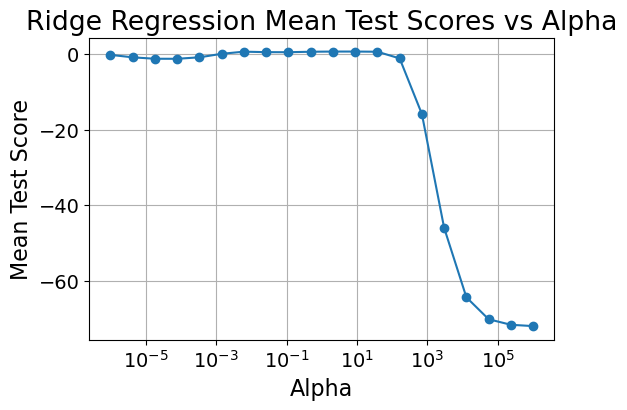

In [224]:
pipeline = make_pipeline(StandardScaler(), Ridge())

alphas = np.logspace(-6, 6, 20)

test_scores = []
for alpha in alphas:
    pipeline.set_params(ridge__alpha=alpha)
    cv_scores = cross_validate(pipeline, new_xb, ypb, cv=5)
    
    test_scores.append(np.mean(cv_scores['test_score']))

best_alpha = alphas[np.argmax(test_scores)]
print("Best alpha:", best_alpha)

plt.plot(alphas, test_scores, marker='o')
plt.xscale('log') 
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Ridge Regression Mean Test Scores vs Alpha')
plt.grid(True)
plt.show()

There is a built-in routine for this hyperparameter optimization scan called RidgeCV. Try it out, do you get the same answer as before?

**Different answer**

In [225]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(new_xb, ypb)

best_alpha_cv = ridge_cv.alpha_
print("Best alpha using RidgeCV:", best_alpha_cv)

Best alpha using RidgeCV: 695.1927961775591


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.61533e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.54506e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.42877e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.38878e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:20

The coefficients of the linear model are strongly affected by regularization. Pick one or two of the features and plot the absolute value of the coefficient for the range of alphas used above in the search scan.  Which scale makes most sense for this plot, linear or logarithmic?

Remember that the data must be standardized for this comparison to make sense, so either use a pipeline or fit_transform your data first to standard form using StandardScaler.

**Again, log scale is more appropriate**

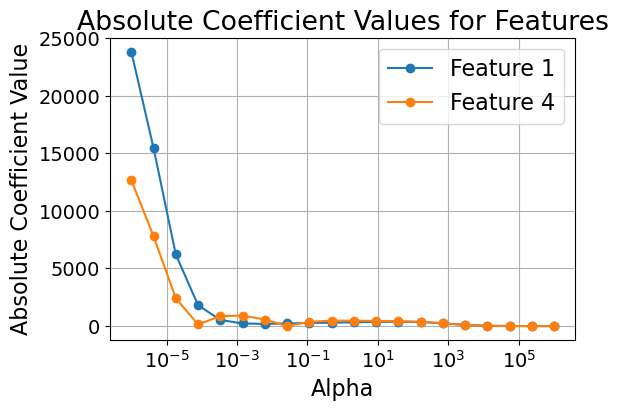

In [226]:
scaler = StandardScaler()
new_xb_scaled = scaler.fit_transform(new_xb)

coef_1 = []
coef_4 = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(new_xb_scaled, ypb)
    coef_1.append(np.abs(ridge.coef_[0]))
    coef_4.append(np.abs(ridge.coef_[3]))

plt.plot(alphas, coef_1, marker='o', label='Feature 1')
plt.plot(alphas, coef_4, marker='o', label='Feature 4')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Absolute Coefficient Value')
plt.title('Absolute Coefficient Values for Features')
plt.grid(True)
plt.legend()
plt.show()

## Step 3: Lasso regression

Repeat the items of step 2 for Lasso regression, now for a smaller range of alpha values $10^{-1}$ and $10^4$. Also, to avoid numerical instabilities, in Lasso set the parameters *max_iter = 10000000, tol = 1e-6*

Best alpha: 0.18329807108324356


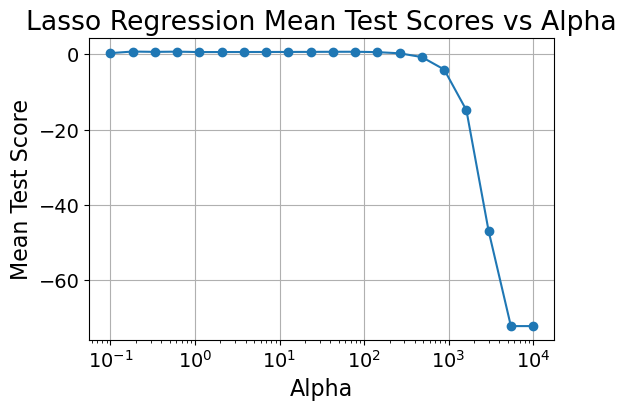

In [227]:
pipeline = make_pipeline(StandardScaler(), Lasso(max_iter=10000000, tol=1e-6))
alphas = np.logspace(-1, 4, 20)

test_scores = []
for alpha in alphas:
    pipeline.set_params(lasso__alpha=alpha)
    cv_scores = cross_validate(pipeline, new_xb, ypb, cv=5)
    
    test_scores.append(np.mean(cv_scores['test_score']))
    
best_alpha = alphas[np.argmax(test_scores)]
print("Best alpha:", best_alpha)

plt.plot(alphas, test_scores, marker='o')
plt.xscale('log') 
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Lasso Regression Mean Test Scores vs Alpha')
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.097e+06, tolerance: 1.559e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+06, tolerance: 1.559e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+06, toleranc

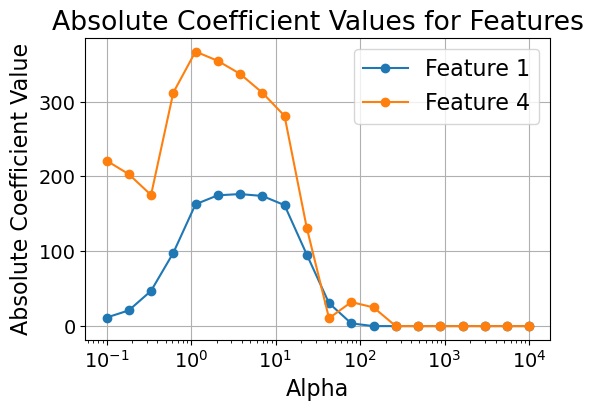

In [228]:
scaler = StandardScaler()
new_xb_scaled = scaler.fit_transform(new_xb)

coef_1 = []
coef_4 = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(new_xb_scaled, ypb)
    coef_1.append(np.abs(lasso.coef_[0]))
    coef_4.append(np.abs(lasso.coef_[3]))

plt.plot(alphas, coef_1, marker='o', label='Feature 1')
plt.plot(alphas, coef_4, marker='o', label='Feature 4')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Absolute Coefficient Value')
plt.title('Absolute Coefficient Values for Features')
plt.grid(True)
plt.legend()
plt.show()

## Step 4: Logistic regression

Logistic regression can be used as a classifier on categorical data. To check it out, let's revisit the habitable planet data set from Lab 3, *HPLearningSet.csv*.

Load the data set and create a feature matix X with the first two features, mass and period. Fit sklearn's *LogisticRegression(random_state=1,penalty=None)*, print the prediction and the accuracy for this model.

In [229]:
data = pd.read_csv('HPLearningSet.csv')

X = data[['S_MASS', 'P_PERIOD']]
y = data['P_HABITABLE']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

log_reg = LogisticRegression(random_state=1, penalty=None)
log_reg.fit(X_train, y_train)

y_pred_sk = log_reg.predict(X_test)

accuracy_sk = accuracy_score(y_test, y_pred)
print("Predictions:", y_pred_sk)
print("Accuracy:", accuracy_sk)

Predictions: [0 0 0 0]
Accuracy: 0.75


Now we will try to create our own implementation of logistic regression, using gradient descent. The relevant loss function is the negative of eq. (5.25). First, you need to compute analytically the gradient of the loss function wrt. $\beta$. This replace the MSE loss in your gradient descent code from lab 10. To facilitate the code, it is useful to also define the sigmoid function eq. (5.21) that returns the probabilities that you will need in the gradient. You could then define another function *predict* that takes the probabilities and returns either 0 or 1, depending on whether the probabilities are less than or greater than 0.5.

We can set *np.random.seed(1)* to intialize a suitable solution vector. Remember that a column of ones must be added to the feature matrix X just as before to take care of the offset. Try starting with a learning rate of $\eta=0.0001$. 

Print the accuracy and predictions of your own logistic regression and compare to sklearn's answer. You might need a quite large number of iterations (up to $10^6$) to reach the same predictions.

In [231]:
data = pd.read_csv('HPLearningSet.csv')
X = data[['S_MASS', 'P_PERIOD']]
y = data['P_HABITABLE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [232]:
learning_rate=0.0001
num_iterations=10**6


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, beta):
    prob = sigmoid(np.dot(X, beta))
    pred = np.where(prob >= 0.5, 1, 0)
    return pred


def log_GD(X, y, learning_rate, num_iterations):
    np.random.seed(1)
    m, n = X.shape
    X = np.c_[np.ones((m, 1)), X] 
    
    beta = np.random.randn(n + 1)
    
    for i in range(num_iterations):
        
        # Calculate gradient
        h = sigmoid(np.dot(X, beta))
        grad = np.dot(X.T, (h - y)) / m
        
        beta = beta - (learning_rate * grad )  
    return beta


beta = log_GD(X_train, y_train,0.0001, 10**6)

X_test_one = np.c_[np.ones((len(X_test), 1)), X_test]
predictions = predict(X_test_one, beta)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print("Predictions:", predictions)

Accuracy: 0.75
Predictions: [0 0 0 0]


In [236]:
print("Accuracy Sklearn:", accuracy_sk)
print("Predictions Sklearn :", y_pred_sk)

Accuracy Sklearn: 0.75
Predictions Sklearn : [0 0 0 0]
